# Image features exercise

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.


In [1]:
import random
import numpy as np
from models_utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from models_utils.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each row is the concatenation of all feature vectors for a single image.

In [4]:
from models_utils.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from models_utils.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-3, 5e-2, 1e-6, 0.1]
regularization_strengths = [1e4, 1e3, 5e3, 100]

results = {}
best_val = -1
best_svm = None
best_params = None

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        cv_svm = LinearSVM()
        loss_hist = cv_svm.train(X_train_feats, y_train, learning_rate=learning_rate, 
                              reg=regularization_strength,
                              num_iters= 1000, verbose=False)
        y_train_pred = cv_svm.predict(X_train_feats)
        y_val_pred   = cv_svm.predict(X_val_feats)
        train_accuracy = np.mean(y_train_pred == y_train)
        cv_accuracy = np.mean(y_val_pred == y_val)
        
        results[(learning_rate, regularization_strength)] = (train_accuracy,cv_accuracy)
        
        if cv_accuracy > best_val:
            best_val = cv_accuracy
            best_svm = cv_svm
            best_params = (learning_rate, regularization_strength)

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.196041 val accuracy: 0.205000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.191796 val accuracy: 0.203000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.187653 val accuracy: 0.179000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.210388 val accuracy: 0.182000
lr 1.000000e-03 reg 1.000000e+02 train accuracy: 0.495469 val accuracy: 0.480000
lr 1.000000e-03 reg 1.000000e+03 train accuracy: 0.494469 val accuracy: 0.479000
lr 1.000000e-03 reg 5.000000e+03 train accuracy: 0.494469 val accuracy: 0.483000
lr 1.000000e-03 reg 1.000000e+04 train accuracy: 0.494510 val accuracy: 0.478000
lr 5.000000e-02 reg 1.000000e+02 train accuracy: 0.497857 val accuracy: 0.496000
lr 5.000000e-02 reg 1.000000e+03 train accuracy: 0.499592 val accuracy: 0.485000
lr 5.000000e-02 reg 5.000000e+03 train accuracy: 0.498347 val accuracy: 0.491000
lr 5.000000e-02 reg 1.000000e+04 train accuracy: 0.495755 val accuracy: 0.485000
lr 1.000000e-01 reg 1.000000

In [12]:
# More training
best_svm = LinearSVM()
stats = best_svm.train(X_train_feats, y_train, learning_rate=best_params[0], 
                       reg=best_params[1],
                       num_iters= 30000, verbose=False)

# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.482


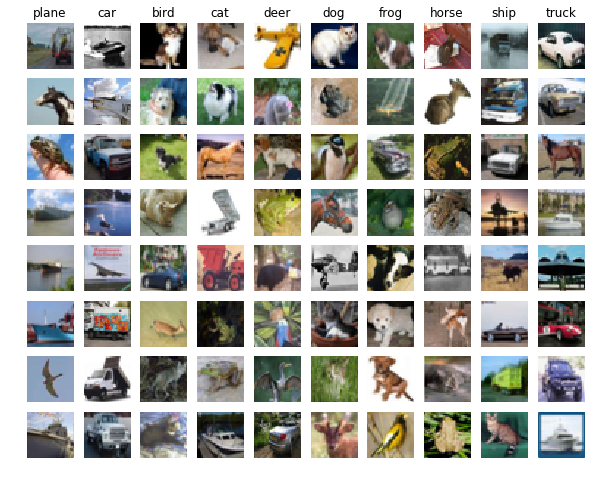

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

- A lot of the misclassifications are due to incomplete framing. For example, Just the end of a horse kind of resembles a curled up cat in complete. A lot of head shots of the animals are hard to classify because then you cannot rely on obvious body features. The model needs to be able to decern complex facial features.
- Occlusion were also present in some mis classfication
- Extreme angles and perspective shots (very cool idea to make a layer that reverses POV abberations, turn into a flat head on perspective image)
- Background artifacts (text, or white circular vignette)

## Comparison with off the shelf one vs all svm in sklearn
What were major differences in the failures of the Multiclass SVM and set of 10 1 vs All SVMs?

It almost seems like some classes never gets picked. Potentially because of the different hyperplanes (and required and average response) for each class classifier. Classifers which produces higher scores by nature will have an advantage to being picked. 